# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [ ]:
dfRetail=pd.read_excel('/content/drive/MyDrive/CAPSTONE 4(customer segmentation)-SHAFIL AHAMED/CSV/Copy of Online Retail.xlsx')

In [ ]:
dfRetail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


 **Exploratory Data Analysis**

 Top 10 ordering countrie

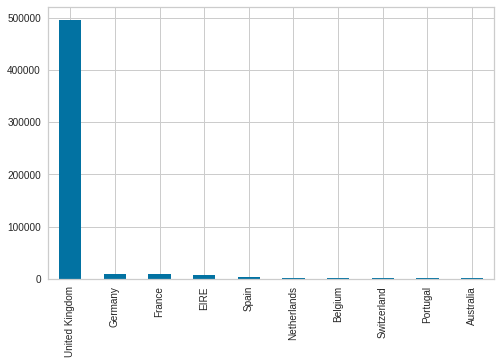

In [ ]:
dfRetail.Country.value_counts().head(10).plot.bar(figsize=(8,5))

**Unique customers and order share of top customers**

In [ ]:
len(dfRetail.CustomerID.unique())

4373


There are 4373 unique customer records in the dataset


In [ ]:
(dfRetail.CustomerID.value_counts()/sum(dfRetail.CustomerID.value_counts())*100).head(n=15).cumsum()

17841.0     1.962249
14911.0     3.413228
14096.0     4.673708
12748.0     5.814728
14606.0     6.498553
15311.0     7.110850
14646.0     7.623350
13089.0     8.079807
13263.0     8.492020
14298.0     8.895138
15039.0     9.265809
14156.0     9.614850
18118.0     9.930462
14159.0    10.228376
14796.0    10.514737
Name: CustomerID, dtype: float64

It is seen that only 10 out of 4000+ customers are responsible for 10% of total orders. These must be the wholesale customers of the retail store

In [ ]:
#Find number of unique items in stock
print(f"Number of unique item stock codes: {len(dfRetail.StockCode.unique())}")
print(f"Number of unique item descriptions: {len(dfRetail.Description.unique())}")

Number of unique item stock codes: 4070
Number of unique item descriptions: 4224


In [ ]:
#Find out the stock units that have more than one description
dfStockDesc = dfRetail.groupby(["StockCode","Description"]).count().reset_index()
dfStockDesc.StockCode.value_counts()[dfStockDesc.StockCode.value_counts()>1].reset_index().head()

,index,StockCode
0,20713,8
1,23084,7
2,85175,6
3,21830,6
4,23343,5


In [ ]:
dfRetail[dfRetail['StockCode'] == 
         dfStockDesc.StockCode.value_counts()
         [dfStockDesc.StockCode.value_counts()>1].reset_index()
         ['index'][8]]['Description'].unique()

array(['SET/3 ROSE CANDLE IN JEWELLED BOX', 'wet pallet', 'damages',
       '???missing', 'AMAZON'], dtype=object)

 **Exploring Quantity and Unit Price fields**

In [ ]:
dfRetail.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

We see 10 goods being sold on an average with a standard deviation of around 200. Also, the minimum quantity includes a negative value, this implies that the dataset includes returned items as well, a common scenario in retail domain

In [ ]:
dfRetail.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

The unit price field echoes the similar observations as Quantity variable

 **Data preprocessing and filtering:**

**Filter UK only data**:   
We noticed in the exploratory data analysis phase that majority of the transactions belonged to UK, so it makes sense to consider only this country data for maximum impact

In [ ]:
dfRetail = dfRetail[dfRetail.Country == "United Kingdom"]

**Exclude records without customer IDs**

In [ ]:
dfRetail = dfRetail[~dfRetail.CustomerID.isnull()]
dfRetail.shape

(361878, 8)

**Feature Engineering - Building features for RFM model:**

**1. Recency:**   
We fix a reference date for finding the recent transactions. The reference date would be a day after the most recent transaction date in the dataset. Then we calculate the days difference between the most recent transaction carried out by the customer and this reference date



In [ ]:
dfRetail['InvoiceDate'] = pd.to_datetime(dfRetail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [ ]:
max_date = max(dfRetail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:49:00')

In [ ]:
dfRetail['Diff'] = max_date - dfRetail['InvoiceDate']
dfRetail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,373 days 04:23:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:23:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,373 days 04:23:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:23:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:23:00


**Recency**

In [ ]:
# Compute last transaction date to get the recency of customers
rfm_r = dfRetail.groupby('CustomerID')['Diff'].min().reset_index()
rfm_r.head()

,CustomerID,Diff
0,12346.0,325 days 02:32:00
1,12747.0,1 days 22:15:00
2,12748.0,0 days 00:29:00
3,12749.0,3 days 02:53:00
4,12820.0,2 days 21:37:00


In [ ]:
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r.columns = ['CustomerID','Recency']
rfm_r.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,1
2,12748.0,0
3,12749.0,3
4,12820.0,2


**Calculating frequency**

In [ ]:
rfm_f = dfRetail.groupby('CustomerID')['InvoiceNo'].count().reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


**Calculating Monetary**

In [ ]:
# New Attribute : Monetary

dfRetail['Amount'] = dfRetail['Quantity']*dfRetail['UnitPrice']
rfm_m = dfRetail.groupby('CustomerID')['Amount'].sum().reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [ ]:
rfm = rfm_r.merge(rfm_f,how='inner',on=['CustomerID'])
rfm =rfm.merge(rfm_m,how='inner',on=['CustomerID'])
rfm.head()

,CustomerID,Recency,Frequency,Amount
0,12346.0,325,2,0.00
1,12747.0,1,103,4196.01
2,12748.0,0,4642,29072.10
3,12749.0,3,231,3868.20
4,12820.0,2,59,942.34


Removing outliers

Text(0.5, 0, 'Attributes')

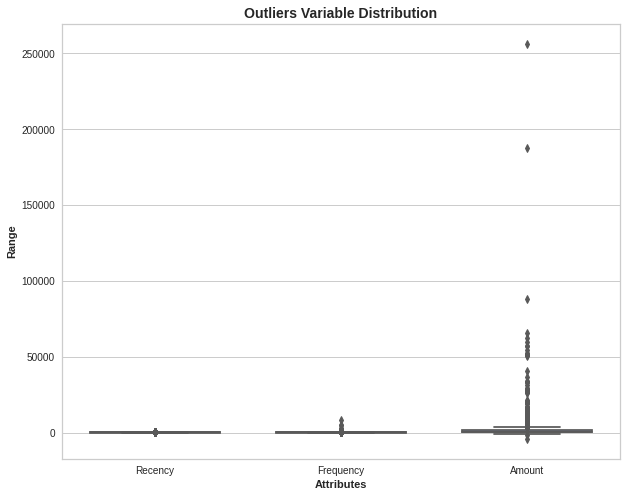

In [ ]:
# Outlier Analysis of Amount Frequency and Recency
import matplotlib.pyplot as plt
import seaborn as sns

attributes = ['Recency','Frequency','Amount',]
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Rescaling the Attributes by Standardisation (mean-0, sigma-1)

In [ ]:
# Rescaling the attributes
import sklearn
from sklearn.preprocessing import StandardScaler

rfm_df = rfm[['Recency','Frequency', 'Amount']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3880, 3)

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()


,Amount,Frequency,Recency
0,2.317310,-0.746427,-0.727974
1,-0.908516,0.256975,1.805920
2,-0.888603,1.528614,1.607962
3,-0.898559,-0.180150,-0.158912
4,1.202210,-0.706688,-0.671982


##**K-MEANS CLUSTERING**

In [ ]:
# k-means with some arbitrary k
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Recency,Frequency,Amount,Cluster_Id
0,12346.0,325,2,0.00,0
1,12747.0,1,103,4196.01,1
3,12749.0,3,231,3868.20,1
4,12820.0,2,59,942.34,3
5,12821.0,213,6,92.72,0


In [ ]:
### visualize the result
import plotly.express as px
rfm["Cluster_Id"] = rfm["Cluster_Id"].astype(str) #convert to string
fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Amount',
              color='Cluster_Id')
fig.show()

**Finding the best K: A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered.**

Method 1: Finding the elbow point for (inertia_) "Sum of squared distances of samples to their closest cluster center".



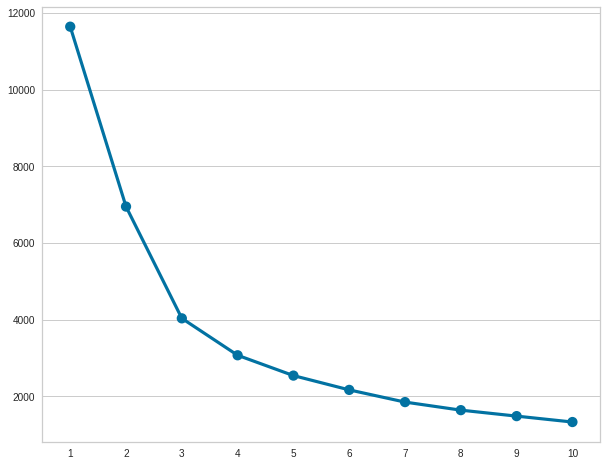

In [ ]:
SSE=[]
for k in range(0,10):
  kmeans=KMeans(n_clusters=k+1,random_state=123).fit(rfm_df_scaled)
  SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)),y=SSE)


This shows an elbow at 4 as after that the decrement is insignificant


AttributeError: ignored

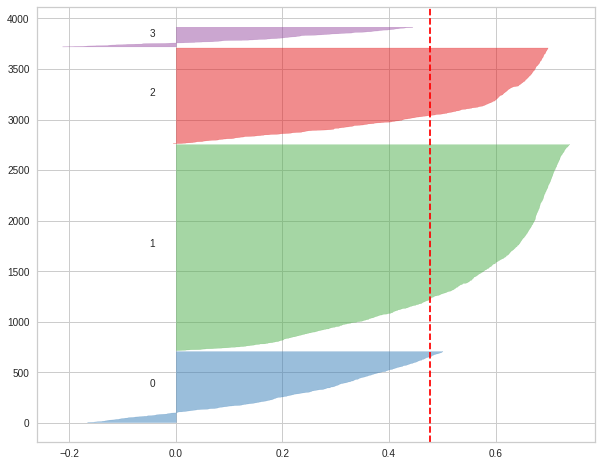

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
model = SilhouetteVisualizer(KMeans(4))
model.fit(rfm_df_scaled)
model.show()

**Now we do a hierarchial clustering**

In [ ]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

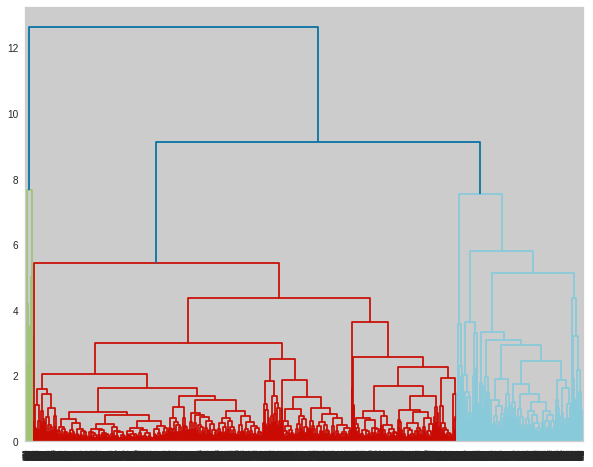

In [ ]:
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

**Summary**   
RFM analysis can segment customers into homogenous group quickly with set of minimum variables. Scoring system can be defined and ranged differently. We get a better result for clustering steps by applying scoring rather than using the raw calculated RFM values. Therefore, segmenting should be done by RFM scoring and further analysis on the spending behavior should be done on the raw values for the targeted cluster to expose more insight and characteristics. RFM analysis solely depends on purchasing behavior and histories, analysis can be further improved by exploring weighted composite scoring or including customer demographic information and product information. A good analysis can increase effectiveness and efficiency of marketing plans, hence increase profitability at minimum cost